In [1]:
import sys
import os
import requests
import torch
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from torch import nn

sys.path.append('..')
from text_conditioned_mae import TextConditionedMaskedAutoencoderViT, copy_weights_mae_textmae, get_mae_vit_large_patch16_text_conditioned
import models_mae

c:\Users\aravi\miniconda3\envs\mml-mae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image_mse(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    reconstructed_image = (y * mask)[0]
    original_image_non_masked = (x * mask)[0]
    mse_loss = torch.nn.functional.mse_loss(reconstructed_image, original_image_non_masked).item()
    return mse_loss

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()


def run_one_image_get_embeddings(img, model, verbose=False):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    imgs = x.float()
    # run MAE
    latents, mask, ids_restore = model.forward_encoder(imgs, mask_ratio=0.75)
    if verbose:
        y = model.forward_decoder(latents, ids_restore)  # [N, L, p*p*3]
        loss = model.forward_loss(imgs, y, mask)
        y = model.unpatchify(y)
        y = torch.einsum('nchw->nhwc', y).detach().cpu()

        # visualize the mask
        mask = mask.detach()
        mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
        mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
        mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
        
        x = torch.einsum('nchw->nhwc', x)

        # masked image
        im_masked = x * (1 - mask)

        # MAE reconstruction pasted with visible patches
        im_paste = x * (1 - mask) + y * mask

        # make the plt figure larger
        plt.rcParams['figure.figsize'] = [24, 24]

        plt.subplot(1, 4, 1)
        show_image(x[0], "original")

        plt.subplot(1, 4, 2)
        show_image(im_masked[0], "masked")

        plt.subplot(1, 4, 3)
        show_image(y[0], "reconstruction")

        plt.subplot(1, 4, 4)
        show_image(im_paste[0], "reconstruction + visible")

        plt.show()
    return latents.detach().cpu().numpy()[0]

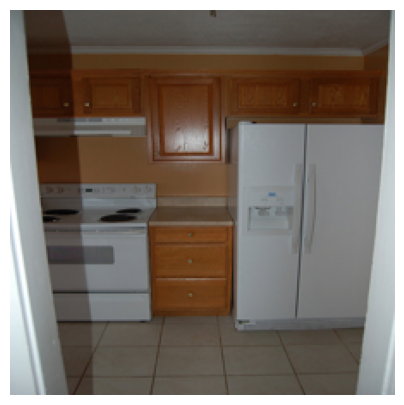

In [3]:
val_dir = "C:\\Users\\aravi\\OneDrive\\Aravind Important\\Carnegie Mellon\\Semesters\\Fall24\\MML\\Project\\Dataset\\val2017"
image_path = os.path.join(val_dir, "000000000802.jpg")
img = Image.open(image_path)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [4]:
chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [11]:
text_conditioned_vitL_P16 = get_mae_vit_large_patch16_text_conditioned()
text_conditioned_vitL_P16 = copy_weights_mae_textmae(model_mae, text_conditioned_vitL_P16)

In [12]:
# A function to calculate all trainable parameters of a pytorch model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_trainable_parameters = count_parameters(text_conditioned_vitL_P16)
print(f'The model has {num_trainable_parameters:,} trainable parameters')

The model has 417,467,136 trainable parameters


In [13]:
type(text_conditioned_vitL_P16), type(model_mae)

(text_conditioned_mae.TextConditionedMaskedAutoencoderViT,
 models_mae.MaskedAutoencoderViT)

In [14]:
def run_one_image_verify_copy(img, text_conditioned_model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = text_conditioned_model(x.float(), None, mask_ratio=0.75, skip_cross_attn=True)
    y = text_conditioned_model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, text_conditioned_model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = text_conditioned_model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

MAE with pixel reconstruction:


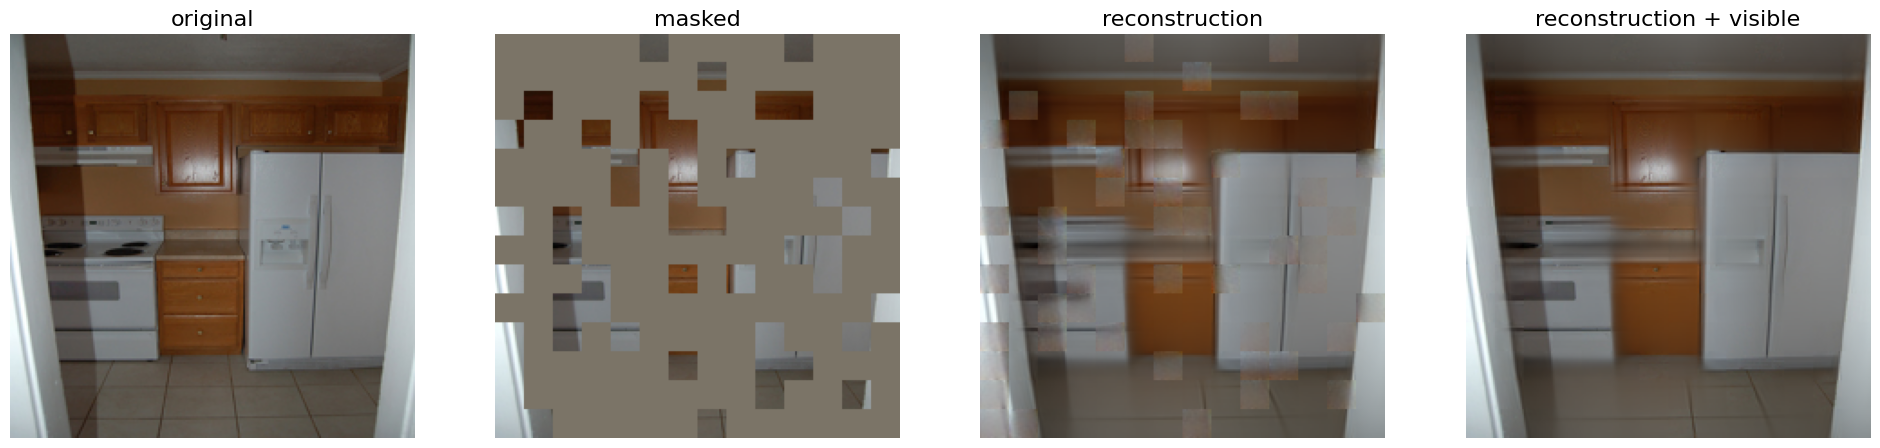

In [15]:
# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image_verify_copy(img, text_conditioned_vitL_P16)

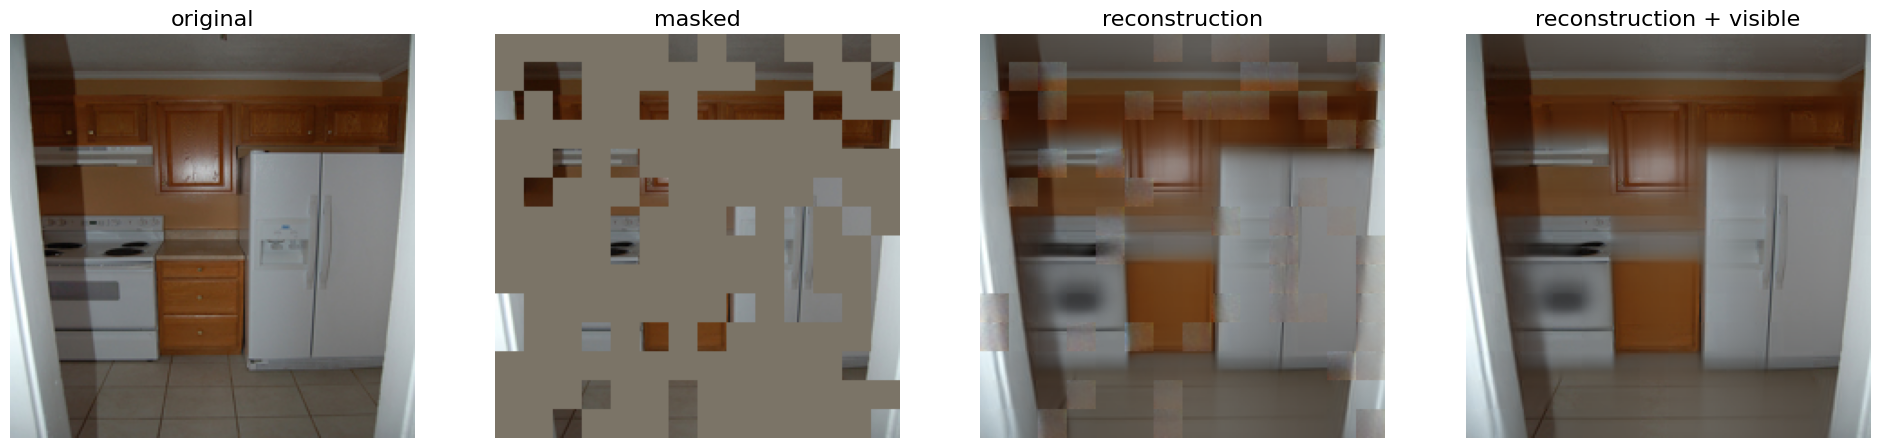

In [16]:
run_one_image(img, model_mae)